https://pytorch.org/audio/stable/tutorials/ctc_forced_alignment_api_tutorial.html

In [16]:
import torch
import torchaudio
device = torch.device("cuda")

In [17]:
SPEECH_FILE = torchaudio.utils.download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav")
waveform, _ = torchaudio.load(SPEECH_FILE)
TRANSCRIPT = "wi biside mi at dis moment".split()

INFO:torchaudio.utils.download:The local file (/home/kawa/.cache/torch/hub/torchaudio/tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav) exists. Skipping the download.


In [22]:
waveform
torch.linalg.vector_norm(waveform, dim=0) - waveform

tensor([[0., 0., 0.,  ..., 0., 0., 0.]])

In [64]:
bundle = torchaudio.pipelines.MMS_FA
model = bundle.get_model(with_star=False).to(device)

with torch.inference_mode():
    emission, _ = model(waveform.to(device))

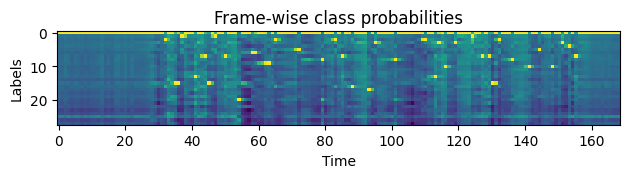

In [65]:
import IPython
import matplotlib.pyplot as plt

import torchaudio.functional as F
def plot_emission(emission):
    fig, ax = plt.subplots()
    ax.imshow(emission.cpu().T)
    ax.set_title("Frame-wise class probabilities")
    ax.set_xlabel("Time")
    ax.set_ylabel("Labels")
    fig.tight_layout()


plot_emission(emission[0])

In [66]:
LABELS = bundle.get_labels(star=None)
DICTIONARY = bundle.get_dict(star=None)
# for k, v in DICTIONARY.items():
#     print(f"{k}: {v}")

In [67]:
tokenized_transcript = [DICTIONARY[c] for word in TRANSCRIPT for c in word]

for t in tokenized_transcript:
    print(t, end=" ")
print()

19 2 17 2 8 2 13 3 10 2 1 7 13 2 8 10 5 10 3 4 7 


In [68]:
def align(emission, tokens):
    targets = torch.tensor([tokens], dtype=torch.int32, device=device)
    alignments, scores = F.forced_align(emission, targets, blank=0)

    alignments, scores = alignments[0], scores[0]  # remove batch dimension for simplicity
    scores = scores.exp()  # convert back to probability
    return alignments, scores


aligned_tokens, alignment_scores = align(emission, tokenized_transcript)

In [69]:
# for i, (ali, score) in enumerate(zip(aligned_tokens, alignment_scores)):
#     print(f"{i:3d}:\t{ali:2d} [{LABELS[ali]}], {score:.2f}")

In [70]:
token_spans = F.merge_tokens(aligned_tokens, alignment_scores)

print("Token\tTime\tScore")
for s in token_spans:
    print(f"{LABELS[s.token]}\t[{s.start:3d}, {s.end:3d})\t{s.score:.2f}")

Token	Time	Score
w	[ 41,  42)	0.00
i	[ 83,  84)	1.00
b	[ 93,  94)	1.00
i	[ 95,  96)	0.00
s	[101, 102)	1.00
i	[110, 111)	1.00
d	[113, 114)	1.00
e	[114, 115)	0.85
m	[116, 117)	1.00
i	[119, 120)	0.00
a	[124, 125)	1.00
t	[127, 128)	1.00
d	[129, 130)	0.00
i	[132, 133)	1.00
s	[136, 137)	1.00
m	[141, 142)	1.00
o	[144, 145)	1.00
m	[148, 149)	1.00
e	[151, 152)	1.00
n	[153, 154)	1.00
t	[155, 156)	1.00


In [71]:
def unflatten(list_, lengths):
    assert len(list_) == sum(lengths)
    i = 0
    ret = []
    for l in lengths:
        ret.append(list_[i : i + l])
        i += l
    return ret


word_spans = unflatten(token_spans, [len(word) for word in TRANSCRIPT])


In [72]:
# Compute average score weighted by the span length
def _score(spans):
    return sum(s.score * len(s) for s in spans) / sum(len(s) for s in spans)


def preview_word(waveform, spans, num_frames, transcript, sample_rate=bundle.sample_rate):
    ratio = waveform.size(1) / num_frames
    x0 = int(ratio * spans[0].start)
    x1 = int(ratio * spans[-1].end)
    print(f"{transcript} ({_score(spans):.2f}): {x0 / sample_rate:.3f} - {x1 / sample_rate:.3f} sec")
    segment = waveform[:, x0:x1]
    return IPython.display.Audio(segment.numpy(), rate=sample_rate)


num_frames = emission.size(1)

In [73]:
# Generate the audio for each segment
print(TRANSCRIPT)
IPython.display.Audio(SPEECH_FILE)

['wi', 'biside', 'mi', 'at', 'dis', 'moment']


In [74]:
preview_word(waveform, word_spans[0], num_frames, TRANSCRIPT[0])


wi (0.50): 0.825 - 1.690 sec


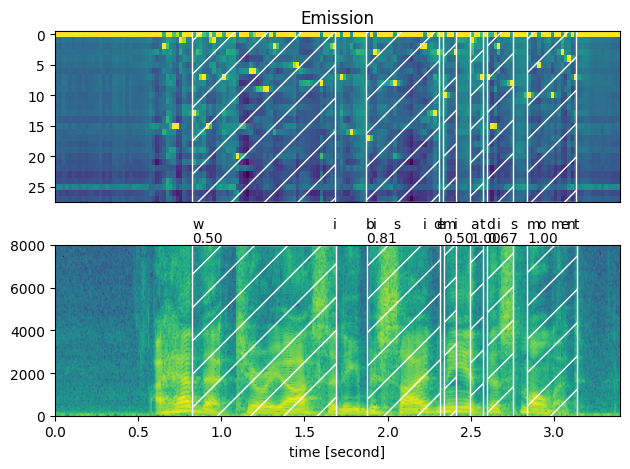

In [75]:
def plot_alignments(waveform, token_spans, emission, transcript, sample_rate=bundle.sample_rate):
    ratio = waveform.size(1) / emission.size(1) / sample_rate

    fig, axes = plt.subplots(2, 1)
    axes[0].imshow(emission[0].detach().cpu().T, aspect="auto")
    axes[0].set_title("Emission")
    axes[0].set_xticks([])

    axes[1].specgram(waveform[0], Fs=sample_rate)
    for t_spans, chars in zip(token_spans, transcript):
        t0, t1 = t_spans[0].start + 0.1, t_spans[-1].end - 0.1
        axes[0].axvspan(t0 - 0.5, t1 - 0.5, facecolor="None", hatch="/", edgecolor="white")
        axes[1].axvspan(ratio * t0, ratio * t1, facecolor="None", hatch="/", edgecolor="white")
        axes[1].annotate(f"{_score(t_spans):.2f}", (ratio * t0, sample_rate * 0.51), annotation_clip=False)

        for span, char in zip(t_spans, chars):
            t0 = span.start * ratio
            axes[1].annotate(char, (t0, sample_rate * 0.55), annotation_clip=False)

    axes[1].set_xlabel("time [second]")
    axes[1].set_xlim([0, None])
    fig.tight_layout()
plot_alignments(waveform, word_spans, emission, TRANSCRIPT)

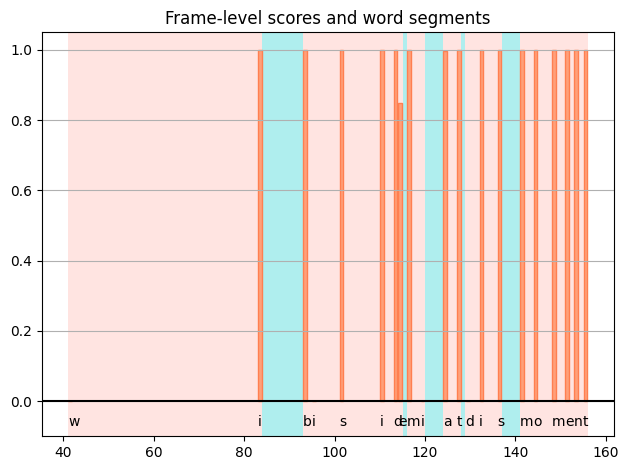

In [76]:
def plot_scores(word_spans, scores):
    fig, ax = plt.subplots()
    span_xs, span_hs = [], []
    ax.axvspan(word_spans[0][0].start - 0.05, word_spans[-1][-1].end + 0.05, facecolor="paleturquoise", edgecolor="none", zorder=-1)
    for t_span in word_spans:
        for span in t_span:
            for t in range(span.start, span.end):
                span_xs.append(t + 0.5)
                span_hs.append(scores[t].item())
            ax.annotate(LABELS[span.token], (span.start, -0.07))
        ax.axvspan(t_span[0].start - 0.05, t_span[-1].end + 0.05, facecolor="mistyrose", edgecolor="none", zorder=-1)
    ax.bar(span_xs, span_hs, color="lightsalmon", edgecolor="coral")
    ax.set_title("Frame-level scores and word segments")
    ax.set_ylim(-0.1, None)
    ax.grid(True, axis="y")
    ax.axhline(0, color="black")
    fig.tight_layout()


plot_scores(word_spans, alignment_scores)
